In [1]:
# ===== 模块导入 =====
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from scipy.stats import ttest_ind
from deap import base, creator, tools, algorithms
import random
import warnings
from draw import *

In [2]:

# ===== 设置输出格式和告警 =====
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ===== 读取数据 =====
df = pd.read_csv(r'C:\Users\WENVM\Desktop\hypertension_data.csv')
df.shape

(92443, 26)

In [4]:
# 处理数据，将原始英文列名转化成中文
reverse_dict =  {
    'age': '年龄',
    'height': '身高',
    'weight': '平均体重',
    'bmi': 'BMI',
    'pregnancy_method': '妊娠方式',
    'family_history': '家族史',
    'pre_gestational_diabetes': '孕前糖尿病',
    'pre_gestational_hypertension': '孕前高血压',
    'urea': '尿素',
    'cystatin_C': '胱抑素C',
    'total_cholesterol': '总胆固醇',
    'pregnancy_count': '怀孕次数',
    'abortion_count': '流产次数',
    'delivery_count': '生产次数',
    'triglycerides': '甘油三酯',
    'papp_a_mom': '血浆蛋白-A',
    'serum_PLG': '血清PLG',
    'uric_acid': '尿酸',
    'prenatal_visits': '产检次数',
    'smoking': '抽烟',
    'alcohol_use': '饮酒',
    'pre_pc_ovarian_syndrome': '孕前卵巢多囊综合征',
    'pre_nephritis': '孕前肾炎',
    'pre_proteinuria': '孕前蛋白尿',
    'creatinine': '肌酐',
    'gh_labels': '妊娠期高血压',
}
df.rename(columns=reverse_dict, inplace=True)
df

,年龄,身高,BMI,平均体重,妊娠方式,家族史,孕前糖尿病,孕前高血压,尿素,胱抑素C,...,血清PLG,尿酸,产检次数,抽烟,饮酒,孕前卵巢多囊综合征,孕前肾炎,孕前蛋白尿,肌酐,妊娠期高血压
0,34,163.5,33.2,89.4,0,0,0,0,5.23,0.75,...,247.541764,282.007790,14,0,0,0,0,0,57.009175,0
1,29,166.3,27.0,74.8,0,0,0,0,3.68,0.75,...,171.528371,272.752635,3,1,0,0,0,0,57.447151,0
2,27,163.2,32.4,88.1,0,0,0,0,5.32,0.91,...,217.192311,201.841873,10,0,0,0,0,0,71.372301,0
3,29,160.0,29.8,75.4,0,0,0,0,4.64,0.65,...,208.244461,220.703546,6,0,0,0,0,0,94.907515,0
4,34,159.0,25.3,64.0,0,0,0,0,2.75,0.88,...,157.597231,234.614458,11,0,0,0,0,0,79.265204,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92438,34,158.7,27.1,66.4,0,0,0,0,1.92,0.85,...,221.808646,395.266403,13,0,0,0,0,0,51.008197,0
92439,34,165.7,28.0,77.2,0,1,0,0,2.45,0.69,...,239.386878,297.839082,13,0,0,0,0,0,59.521609,0
92440,31,156.6,26.7,66.4,0,1,0,0,2.46,0.91,...,218.065313,306.646754,10,0,0,0,0,0,92.337767,0
92441,27,158.8,26.8,64.8,0,0,0,0,3.44,0.79,...,204.878021,173.919245,9,0,0,1,0,0,91.895115,1


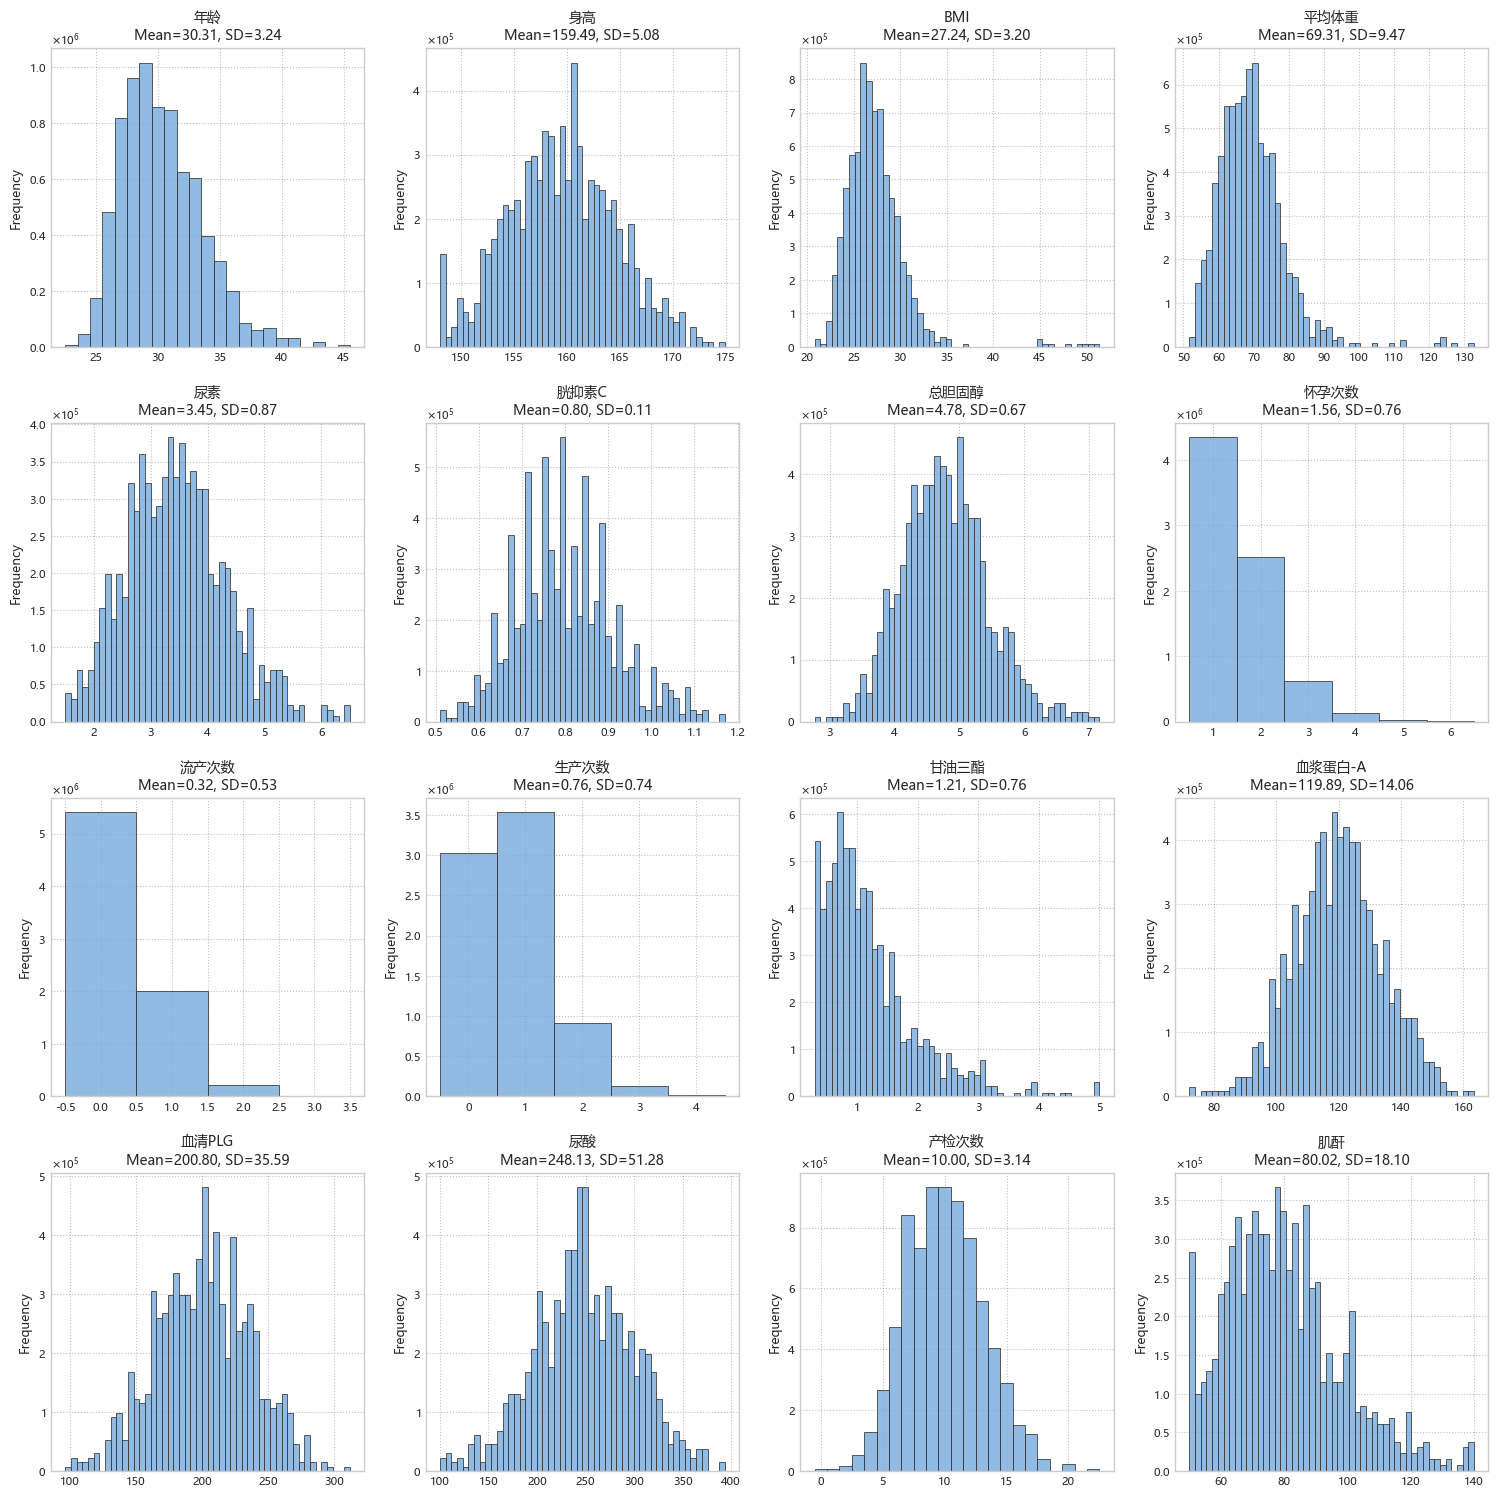

In [5]:
# 筛选菲尔元数据并打印分布
non_binary_features = df.copy()

# 遍历所有列，检查是否为二元数据
for col in df.columns:
    unique_vals = df[col].dropna().unique()
    if len(unique_vals) == 2:  # 如果只有两种唯一值，则认为是二元数据
        non_binary_features.drop(columns=[col], inplace=True)
        
# 为打印效率，将数据采样并打印分布
plot_distributions(data=df.iloc[:5000].copy(), plots_per_figure= 16)

In [6]:
# 数据预处理
# 删除无关列（删除BMI，孕前肾炎，孕前蛋白尿）
df.drop(['BMI', '孕前肾炎', '孕前蛋白尿'], axis=1, inplace=True)
# 使用平均值填补缺失值
df.fillna(df.mean(), inplace=True)
df.shape

(2998, 23)

In [7]:
# ===== t检验分析 =====
print("【t检验分析】")
features = df.columns[:-1]
for col in features:
    t_stat, p_val = ttest_ind_(df[df['妊娠期高血压'] == 1][col], df[df['妊娠期高血压'] == 0][col], equal_var=False, col_name=col)
    print(f"{col}：t={t_stat:.3f}, p={p_val:.5f}")

【t检验分析】
年龄：t=5.059, p=0.00000
身高：t=9.611, p=0.00000
平均体重：t=7.883, p=0.00000
妊娠方式：t=6.829, p=0.00000
家族史：t=3.333, p=0.00090
孕前糖尿病：t=3.332, p=0.00090
孕前高血压：t=2.559, p=0.01060
尿素：t=9.762, p=0.00000
胱抑素C：t=8.676, p=0.00000
总胆固醇：t=3.777, p=0.00020
怀孕次数：t=4.401, p=0.00000
流产次数：t=6.934, p=0.00000
生产次数：t=3.202, p=0.00140
甘油三酯：t=3.536, p=0.00040
血浆蛋白-A：t=3.549, p=0.00040
血清PLG：t=4.504, p=0.00000
尿酸：t=6.246, p=0.00000
产检次数：t=5.512, p=0.00000
抽烟：t=4.408, p=0.00000
饮酒：t=4.994, p=0.00000
孕前卵巢多囊综合征：t=8.943, p=0.00000
肌酐：t=2.263, p=0.02390


In [8]:
# 划分数据集
X = df.drop(columns="妊娠期高血压")
y = df["妊娠期高血压"]
# 数据标准化
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
print(X_scaled.iloc[:10, :5])

         年龄        身高      平均体重  妊娠方式  家族史
0  0.500000  0.547703  0.393885   0.0  0.0
1  0.272727  0.646643  0.262590   0.0  0.0
2  0.181818  0.537102  0.382194   0.0  0.0
3  0.272727  0.424028  0.267986   0.0  0.0
4  0.500000  0.388693  0.165468   0.0  0.0
5  0.818182  0.593640  0.209532   0.0  1.0
6  0.500000  0.731449  0.220324   0.0  0.0
7  0.318182  0.388693  0.251799   0.0  0.0
8  0.272727  0.371025  0.155576   1.0  0.0
9  0.454545  0.310954  0.189748   0.0  0.0


In [9]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
# 训练集和验证集的分布
print("训练集分布：")
print(y_train.value_counts())
print("验证集分布：")
print(y_test.value_counts())

训练集分布：
妊娠期高血压
0    2179
1     219
Name: count, dtype: int64
验证集分布：
妊娠期高血压
0    545
1     55
Name: count, dtype: int64


In [10]:
# 使用smote方法扩展训练集数据
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)
# 训练集和验证集的分布
print("训练集分布：")
print(y_train_smote.value_counts())

训练集分布：
妊娠期高血压
0    2179
1    2179
Name: count, dtype: int64


In [11]:
# ===== 遗传算法优化函数定义 =====
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def create_individual():
    return [random.randint(50, 200), random.randint(3, 15), random.randint(2, 10)]

def evaluate_rf_orig(ind):
    model = RandomForestClassifier(n_estimators=int(ind[0]), max_depth=int(ind[1]), min_samples_split=int(ind[2]), random_state=42)
    model.fit(X_train, y_train)
    return (roc_auc_score(y_test, model.predict(X_test)),)

def evaluate_rf_smote(ind):
    model = RandomForestClassifier(n_estimators=int(ind[0]), max_depth=int(ind[1]), min_samples_split=int(ind[2]), random_state=42)
    model.fit(X_train_smote, y_train_smote)
    return (roc_auc_score(y_test, model.predict(X_test)),)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutPolynomialBounded, low=[50, 3, 2], up=[200, 15, 10], eta=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [12]:
# ===== 遗传算法优化原始RF参数 =====
toolbox.register("evaluate", evaluate_rf_orig)
pop1 = toolbox.population(n=10)
algorithms.eaSimple(pop1, toolbox, cxpb=0.6, mutpb=0.3, ngen=10, verbose=False)
best_orig = tools.selBest(pop1, 1)[0]

# ===== 遗传算法优化SMOTE+RF参数 =====
toolbox.unregister("evaluate")
toolbox.register("evaluate", evaluate_rf_smote)
pop2 = toolbox.population(n=10)
algorithms.eaSimple(pop2, toolbox, cxpb=0.6, mutpb=0.3, ngen=10, verbose=False)
best_smote = tools.selBest(pop2, 1)[0]

In [13]:
# ===== 构建随机森林模型 =====
# 原始模型rf_orig
rf_orig = RandomForestClassifier(n_estimators=int(best_orig[0]), max_depth=int(best_orig[1]), min_samples_split=int(best_orig[2]), random_state=42);best_orig=best_orig_2
rf_orig.fit(X_train, y_train)
y_pred_orig = rf_orig.predict(X_test)
y_prob_orig = rf_orig.predict_proba(X_test)[:, 1]

# 优化模型rf_smote
rf_smote = RandomForestClassifier(n_estimators=int(best_smote[0]), max_depth=int(best_smote[1]), min_samples_split=int(best_smote[2]), random_state=42);best_smote=best_smote_2
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test)
y_prob_smote = rf_smote.predict_proba(X_test)[:, 1]

# 逻辑回归模型
logit = LogisticRegression(max_iter=200)
logit.fit(X_train, y_train)
y_pred_logit = logit.predict(X_test)
y_prob_logit = logit.predict_proba(X_test)[:, 1]

# 打印最优化参数
# 输出格式：最大树数量，最大特征，最大树深
print("原始RF模型参数：", best_orig)
print("SMOTE+RF模型参数：", best_smote)
print("Logistic回归模型参数：", logit.get_params())

原始RF模型参数： [102, 3, 7]
SMOTE+RF模型参数： [39, 8, 13]
Logistic回归模型参数： {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [14]:
# ===== 模型评估 =====
def print_metrics(name, y_true, y_pred, y_prob):
    print(f"\n模型：{name}")
    print("准确率：", round(accuracy_score(y_true, y_pred), 4))
    print("查准率：", round(precision_score(y_true, y_pred), 4))
    print("查全率：", round(recall_score(y_true, y_pred), 4))
    print("AUC值：", round(roc_auc_score(y_true, y_prob), 4))

print_metrics("逻辑回归", y_test, y_pred_logit, y_prob_logit)
print_metrics("未使用SMOTE的随机森林", y_test, y_pred_orig, y_prob_orig)
print_metrics("使用SMOTE的随机森林", y_test, y_pred_smote, y_prob_smote)


模型：逻辑回归
准确率： 0.9183
查准率： 1.0
查全率： 0.1091
AUC值： 0.7316

模型：未使用SMOTE的随机森林
准确率： 0.915
查准率： 1.0
查全率： 0.0727
AUC值： 0.7408

模型：使用SMOTE的随机森林
准确率： 0.75
查准率： 0.1724
查全率： 0.4545
AUC值： 0.6459


In [15]:
# ===== 十折交叉验证 AUC =====
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n【十折交叉验证 AUC】")
print("逻辑回归：", round(cross_val_score(logit, X_scaled, y, cv=cv, scoring='roc_auc').mean(), 4))
print("未使用SMOTE的随机森林：", round(cross_val_score(rf_orig, X_scaled, y, cv=cv, scoring='roc_auc').mean(), 4))
print("使用SMOTE的随机森林：", round(cross_val_score(rf_smote, X_scaled, y, cv=cv, scoring='roc_auc').mean(), 4))



【十折交叉验证 AUC】
逻辑回归： 0.7244
未使用SMOTE的随机森林： 0.6696
使用SMOTE的随机森林： 0.6957


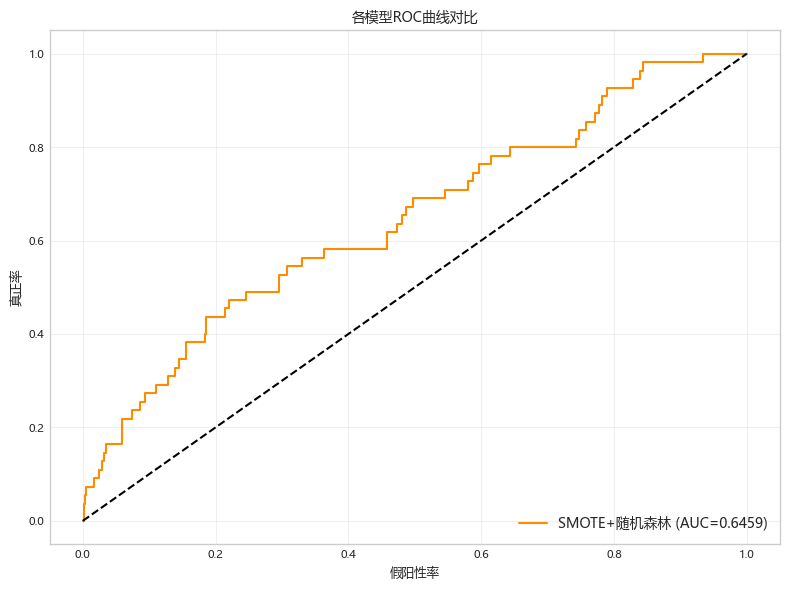

In [17]:
# ===== ROC曲线绘制 =====
plt.figure(figsize=(8, 6))
label, y_prob, color =  "SMOTE+随机森林", y_prob_smote, 'darkorange'
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_test, y_prob):.4f})", color=color)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("假阳性率")
plt.ylabel("真正率")
plt.title("各模型ROC曲线对比")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

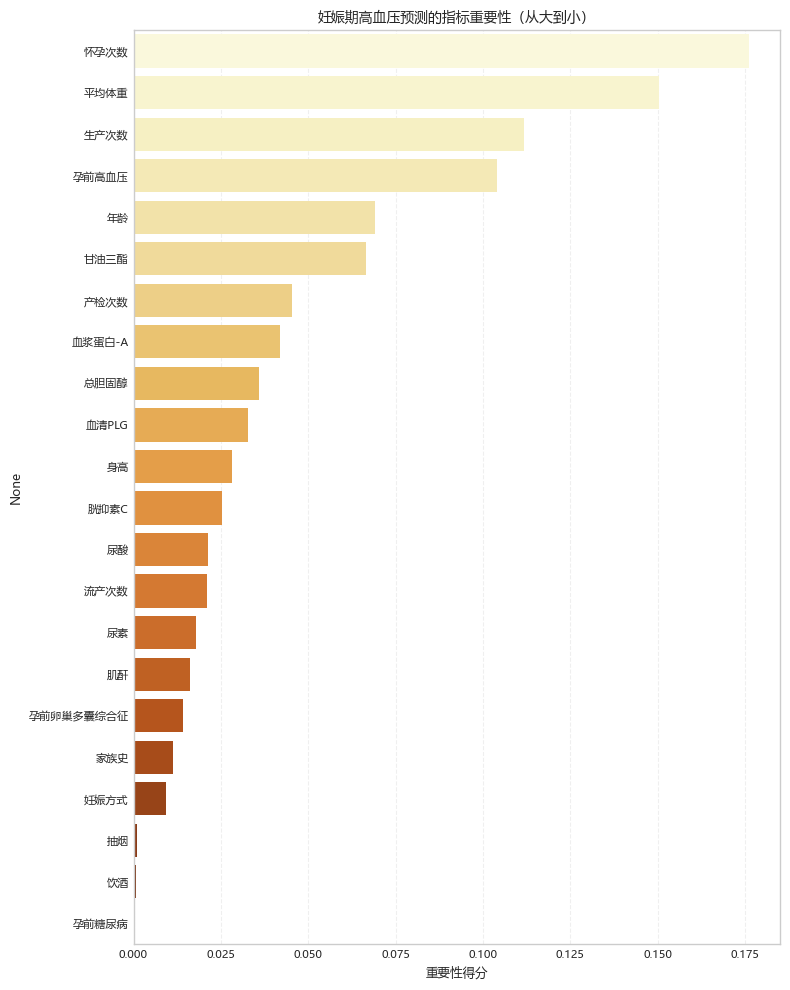

In [18]:
# ===== 特征重要性分析 =====
importances = pd.Series(rf_smote.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 10))
sns.barplot(x=importances.values, y=importances.index, palette="YlOrBr")
plt.title("妊娠期高血压预测的指标重要性（从大到小）")
plt.xlabel("重要性得分")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

